### 1. Import libraries and get data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

In [3]:
# Load the dataset
df = pd.read_csv("./ETH.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-05-12,86.99
2017-05-13,89.90
2017-05-14,90.37
2017-05-15,92.56
2017-05-16,88.17
...,...
2023-06-08,1845.68
2023-06-09,1840.41
2023-06-10,1751.56


Forecasting Horizon Explained

In [4]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Lag features

In [5]:
def add_lags(df):
    target_map = df['Price'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

### 2. Split the data into training, test and validate sets

In [6]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1556, 12)
Test shape: (333, 12)
Validate shape: (334, 12)


In [7]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1333, 12)
Test shape: (444, 12)
Validate shape: (446, 12)


In [8]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

Train shape: (1556, 12)
Test shape: (444, 12)
Validate shape: (223, 12)


## 3. Perform XGBoost Model

### 3.1 Build and fit XGBoost Model with train data

In [9]:
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
target = 'Price'

x_train = train_data[features]
y_train = train_data[target]

x_val = val_data[features]
y_val = val_data[target]

x_test = test_data[features]
y_test = test_data[target]

xgb_model = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

xgb_model.fit(x_train, y_train, eval_set=[(df[features], df[target])], early_stopping_rounds=50, verbose=False)

[01:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

### 3.2 Evaluate on Validate data

In [10]:
def evaludate_xgb_model(x_data, y_data):
    predictions = xgb_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [11]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_xgb_model(x_val, y_val)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [2728.806  2728.806  2728.284  2728.284  2728.284  2728.284  2728.284
 2728.284  2728.284  2726.7092 2728.284  2728.284  2728.284  2726.7092
 2726.7092 2728.284  2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092 2726.7092
 2726.7092 2726.7092 2726.7092 2726.7092 1431.012  1431.012  1431.012
 1438.7749 1465.8687 1485.7957 1485.7957 1485.7957 1485.7957 1485.7957
 1485.7957 1485.7957 1485.7957 1485.7957 1485.7957 1506.2274 1508.1595
 1519.0598 1522.1107 1522.1107 1522.1107 1522.1107 1522.1107 1572.1752
 1572.1752 1572.1752 1572.1752 1572.1752 1587.1245 1587.5858 1587.5858
 1597.0663 1733.335  1848.8541 1848.8541 1886.9

### 3.3 Evaluate on Test data

In [12]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_xgb_model(x_test, y_test)

print("Price predict on test data:", y_pred_test)

Price predict on test data: [2879.1223 2879.1223 2879.1223 2879.1223 2879.1223 2879.1223 2879.1223
 2879.1223 2879.1223 2879.1223 2879.1223 2871.3718 2871.3718 2879.1223
 2871.3718 2879.1223 2878.6226 2879.1223 2879.1223 2871.3718 2690.2385
 2762.8262 2762.8262 2688.637  2762.8262 2778.9739 2778.9739 2846.2932
 2778.9739 2846.2932 2778.9739 2778.9739 2846.2932 2846.2932 2846.2932
 2778.9739 2688.637  2755.0757 2646.4785 2755.0757 2762.8262 2762.8262
 2755.0757 2762.8262 2778.9739 2778.9739 2762.8262 2762.8262 2762.8262
 2762.8262 2762.8262 2688.637  2688.637  2762.8262 2778.9739 2778.9739
 2778.9739 2846.2932 2846.2932 2846.2932 2846.2932 2778.9739 2778.9739
 2846.2932 2846.2932 2778.9739 2838.5427 2838.5427 2846.2932 2846.2932
 2846.2932 2846.2932 2846.2932 2846.2932 2846.2932 2846.2932 2846.2932
 2846.2932 2846.2932 2846.2932 2846.2932 2846.2932 2845.7935 2846.2932
 2845.7935 2845.7935 2845.7935 2845.7935 2845.7935 2845.7935 2845.7935
 2845.7935 2845.7935 2845.7935 2845.7935 2838.043

### 3.4 Predict price for the next 30 days

In [13]:
future_range = pd.date_range(start=df.index[-1], periods=30, freq='D')
future_df = pd.DataFrame(index=future_range)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()


# Predict the closing prices for the next 30 days
y_next_30_days = xgb_model.predict(future_w_features[features])

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[2357.6194 2357.6194 2357.6194 2357.6194 2344.3884 2344.3884 2319.6528
 2297.2097 2297.2097 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321
 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321
 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321 2238.4321
 2238.4321 2238.4321]


In [14]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE          MAE      MAPE         RMSE
Validate  6.982188e+05   636.610225  0.455880   835.594884
Test      1.259524e+06  1033.967314  0.473388  1122.285095


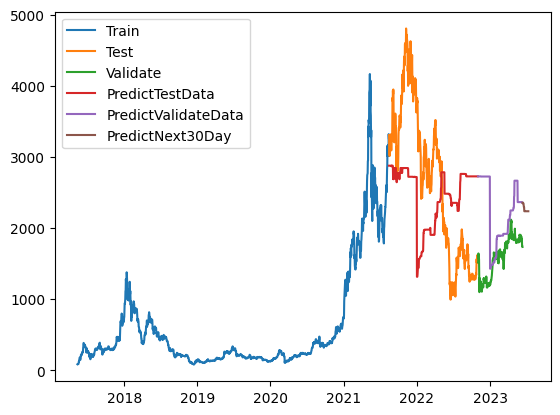

In [16]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(future_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()